In [421]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [422]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('emails.csv')
# my_data = genfromtxt('emails.csv', delimiter=',')
X = df.iloc[1:,1:-1]
# Standardizing the features
X = StandardScaler().fit_transform(X)
X.shape

(5171, 3000)

In [423]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['X', 'Y'])
principalDf

,X,Y
0,7.875806,4.975754
1,-7.866918,-2.731528
2,-1.799964,2.856870
3,-2.060145,2.256114
4,2.098481,-0.372067
...,...,...
5166,-4.534346,-0.290579
5167,14.667014,3.761554
5168,-6.895364,-3.556202
5169,-2.945828,-1.359926


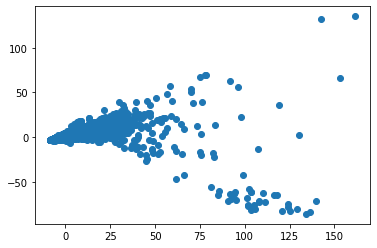

In [425]:
plt.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1])

# Implementation with stack

In [426]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [427]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters
            

In [428]:
#radius of the circle defined as 0.6
eps = 11
#minimum neighbouring points set to 3
minPts = 225


In [429]:
data = pd.DataFrame(principalDf)
clustered = cluster_with_stack(eps, minPts, data)

In [430]:
idx , cluster = list(zip(*clustered))

In [431]:
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

Text(0, 0.5, 'Y')

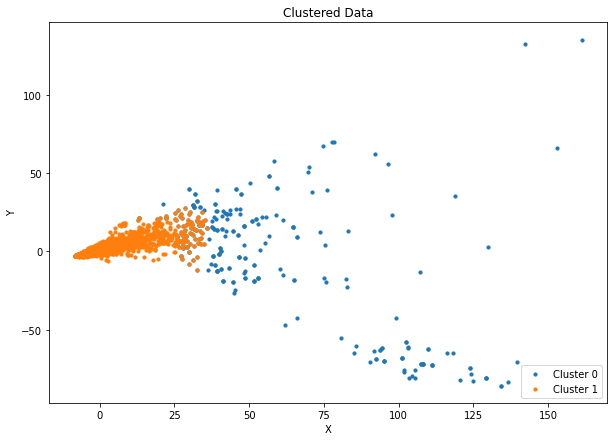

In [432]:
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(principalDf.iloc[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], principalDf.iloc[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')


# Clustering with K-Means

In [433]:
from sklearn.cluster import KMeans


In [434]:
clustering = KMeans(2).fit(principalDf)

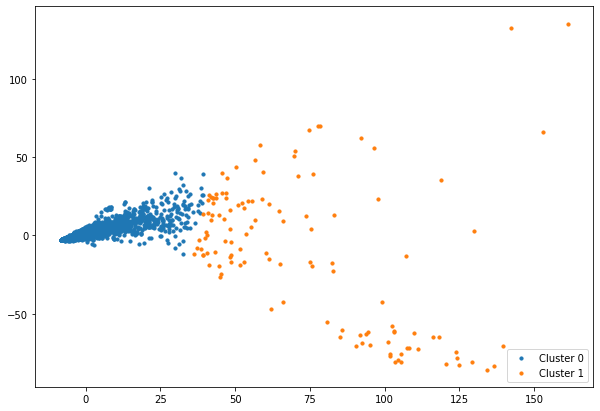

In [435]:
plt.figure(figsize=(10,7))
for clust in np.unique(clustering.labels_):
    plt.scatter(principalDf.iloc[clustering.labels_ == clust, 0], principalDf.iloc[clustering.labels_ == clust, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(clustering.labels_)], loc ="lower right")